In [6]:
# Install required packages (if not already installed in Colab)
%pip install numpy pandas scikit-learn matplotlib

# Import libraries
import os
import numpy as np
import pandas as pd
from dataclasses import dataclass
import math
import argparse
import io
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr

print("Dependencies and imports set up.")

Note: you may need to restart the kernel to use updated packages.
Dependencies and imports set up.


Loaded 1036_.csv from abnormal folder with 3 rows for track ID 1036.
Loaded 1041_1067_.csv from abnormal folder with 14 rows for track ID 1041.
Loaded 108_156_171_174_219_253_279_304_306_324_.csv from abnormal folder with 187 rows for track ID 108.
Loaded 109_.csv from abnormal folder with 331 rows for track ID 109.
Loaded 112_.csv from abnormal folder with 1 rows for track ID 112.
Loaded 117_.csv from abnormal folder with 266 rows for track ID 117.
Loaded 15_.csv from abnormal folder with 2075 rows for track ID 15.
Loaded 166_.csv from abnormal folder with 667 rows for track ID 166.
Loaded 17_.csv from abnormal folder with 622 rows for track ID 17.
Loaded 187_198_209_226_.csv from abnormal folder with 111 rows for track ID 187.
Loaded 18_191_310_365_446_.csv from abnormal folder with 2055 rows for track ID 18.
Loaded 196_.csv from abnormal folder with 371 rows for track ID 196.
Loaded 19_545_922_932_.csv from abnormal folder with 1694 rows for track ID 19.
Loaded 202_.csv from abnorma

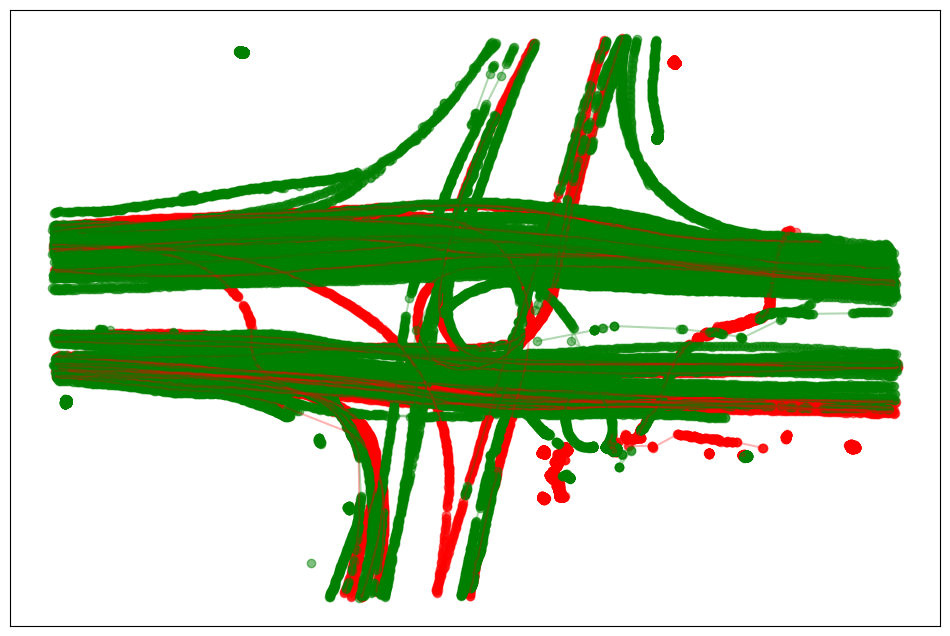

In [7]:
# Set the base directory containing the abnormal and normal subfolders
base_directory = '/home/run/media/localdiskD/Ahmedabad University/6th SEM/ML/ML_2025_4_Cluster_555/dataset/processed/12'

# Define subdirectories for abnormal and normal tracks
abnormal_dir = os.path.join(base_directory, 'abnormal')
normal_dir = os.path.join(base_directory, 'normal')

# Step 1: Load CSV files from both directories
def load_trajectories(abnormal_dir, normal_dir):
    tracks = {}

    # Load abnormal tracks
    if os.path.exists(abnormal_dir):
        abnormal_files = [f for f in os.listdir(abnormal_dir) if f.endswith('.csv')]
        for csv_file in abnormal_files:
            file_path = os.path.join(abnormal_dir, csv_file)
            try:
                df = pd.read_csv(file_path)[['frameNo', 'left', 'top', 'w', 'h']]
                if not df.empty:
                    # Extract track ID (first number before '_', or full filename if no '_')
                    track_id = csv_file.split('_')[0] if '_' in csv_file else csv_file.replace('.csv', '')
                    tracks[track_id] = {'df': df, 'label': 0}  # 0 for abnormal
                    print(f"Loaded {csv_file} from abnormal folder with {len(df)} rows for track ID {track_id}.")
                else:
                    print(f"Warning: {csv_file} is empty and will be skipped.")
            except Exception as e:
                print(f"Error loading {csv_file} from abnormal folder: {e}")
    else:
        print(f"Warning: Abnormal directory {abnormal_dir} not found.")

    # Load normal tracks
    if os.path.exists(normal_dir):
        normal_files = [f for f in os.listdir(normal_dir) if f.endswith('.csv')]
        for csv_file in normal_files:
            file_path = os.path.join(normal_dir, csv_file)
            try:
                df = pd.read_csv(file_path)[['frameNo', 'left', 'top', 'w', 'h']]
                if not df.empty:
                    # Extract track ID (first number before '_', or full filename if no '_')
                    track_id = csv_file.split('_')[0] if '_' in csv_file else csv_file.replace('.csv', '')
                    tracks[track_id] = {'df': df, 'label': 1}  # 1 for normal
                    print(f"Loaded {csv_file} from normal folder with {len(df)} rows for track ID {track_id}.")
                else:
                    print(f"Warning: {csv_file} is empty and will be skipped.")
            except Exception as e:
                print(f"Error loading {csv_file} from normal folder: {e}")
    else:
        print(f"Warning: Normal directory {normal_dir} not found.")

    return tracks

# Step 2: Compute centers
def compute_centers(tracks):
    for track_id, data in tracks.items():
        df = data['df']
        df['center_x'] = df['left'] + df['w'] / 2
        df['center_y'] = df['top'] + df['h'] / 2

# Step 3: Plot all trajectories in one image
def plot_all_trajectories(tracks):
    plt.figure(figsize=(12, 8))
    colors = {'0': 'red', '1': 'green'}  # Red for abnormal, Green for normal

    for track_id, data in tracks.items():
        df = data['df']
        label = str(data['label'])
        color = colors[label]

        # Plot the trajectory without labels
        plt.scatter(df['center_x'], df['center_y'], c=color, alpha=0.5)
        plt.plot(df['center_x'], df['center_y'], c=color, alpha=0.3)

    # Remove labels, title, and legend
    plt.title('')  # Empty title
    plt.xlabel('')  # Empty x-axis label
    plt.ylabel('')  # Empty y-axis label
    plt.grid(False)  # No grid
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks

    # Save the plot as an image
    output_path = os.path.join(base_directory, 'all_trajectories.png')
    plt.savefig(output_path, bbox_inches='tight')
    print(f"Saved plot to {output_path}")

    # Show the plot
    plt.show()

# Main execution
if __name__ == "__main__":
    # Load trajectories from both folders
    tracks = load_trajectories(abnormal_dir, normal_dir)
    if not tracks:
        print("No valid trajectories loaded. Exiting.")
        exit()

    # Compute centers
    compute_centers(tracks)

    # Plot all trajectories in one image
    plot_all_trajectories(tracks)

In [17]:
from typing import List, Dict

# Define a data class for a vehicle's track point
@dataclass
class TrackPoint:
    frame_id: int  # Frame number from CSV (continuous)
    x: float       # 'left' coordinate of bounding box
    y: float       # 'top' coordinate of bounding box
    zone_id: int   # Assigned zone ID

VehicleTrack = List[TrackPoint]

# Define the TrafficAnalyzer class for feature extraction
class TrafficAnalyzer:
    def __init__(self, fps: float, speed_limit: float, zone_definitions: Dict,
                 violation_dict: Dict[str, List[str]], gsd: float):
        """Initialize with project-specific parameters."""
        self.fps = fps
        self.speed_limit = speed_limit
        self.zone_definitions = zone_definitions
        self.violation_dict = violation_dict
        self.gsd = gsd

    def calculate_speed(self, track: VehicleTrack) -> List[float]:
        """Calculate speed using frame differences as time intervals."""
        speeds = []
        for i in range(1, len(track)):
            dx = (track[i].x - track[i-1].x) * self.gsd
            dy = (track[i].y - track[i-1].y) * self.gsd
            distance = math.sqrt(dx**2 + dy**2)
            time = (track[i].frame_id - track[i-1].frame_id) / self.fps
            speed_mps = distance / time if time > 0 else 0
            speed_kmph = speed_mps * 3.6
            speeds.append(speed_kmph)
        return speeds

    def calculate_turn_angle(self, track: VehicleTrack) -> List[float]:
        """Calculate turn angles using three consecutive points."""
        angles = []
        for i in range(2, len(track)):
            v1 = (track[i-1].x - track[i-2].x, track[i-1].y - track[i-2].y)
            v2 = (track[i].x - track[i-1].x, track[i].y - track[i-1].y)
            dot_product = v1[0] * v2[0] + v1[1] * v2[1]
            mag_v1 = math.sqrt(v1[0]**2 + v1[1]**2)
            mag_v2 = math.sqrt(v2[0]**2 + v2[1]**2)
            if mag_v1 * mag_v2 == 0:
                angles.append(0)
                continue
            cos_theta = dot_product / (mag_v1 * mag_v2)
            cos_theta = min(1.0, max(-1.0, cos_theta))
            angle = math.degrees(math.acos(cos_theta))
            angles.append(angle)
        return angles

    def get_zone_sequence(self, track: VehicleTrack) -> List[int]:
        """Get sequence of zones traversed."""
        return [point.zone_id for point in track]
    
    def calculate_total_distance(self, track: VehicleTrack) -> float:
        """Calculate total distance traveled in the trip."""
        total_distance = 0.0
        for i in range(1, len(track)):
            dx = (track[i].x - track[i-1].x) * self.gsd
            dy = (track[i].y - track[i-1].y) * self.gsd
            total_distance += math.sqrt(dx**2 + dy**2)
        return total_distance

    def calculate_avg_acceleration(self, track: VehicleTrack) -> float:
        """Calculate average acceleration across the trip."""
        accelerations = []
        for i in range(1, len(track) - 1):  # Ensure we have next point for speed2
            speed1 = self.calculate_speed([track[i-1], track[i]])[0]
            speed2 = self.calculate_speed([track[i], track[i+1]])[0]
            time_diff = (track[i].frame_id - track[i-1].frame_id) / self.fps
            if time_diff > 0:
                acceleration = (speed2 - speed1) / time_diff
                accelerations.append(acceleration)
        return np.mean(accelerations) if accelerations else 0.0

    def calculate_speed_variance(self, track: VehicleTrack) -> float:
        """Calculate variance of speed values."""
        speeds = self.calculate_speed(track)
        return np.var(speeds) if speeds else 0.0

    def calculate_direction_variance(self, track: VehicleTrack) -> float:
        """Calculate variance of direction angles."""
        angles = self.calculate_turn_angle(track)
        return np.var(angles) if angles else 0.0

    def calculate_path_length_ratio(self, track: VehicleTrack) -> float:
        """Calculate ratio of total path length to straight-line distance."""
        if len(track) < 2:
            return 1.0
        total_distance = self.calculate_total_distance(track)
        start_point = track[0]
        end_point = track[-1]
        straight_distance = math.sqrt(
            ((end_point.x - start_point.x) * self.gsd)**2 +
            ((end_point.y - start_point.y) * self.gsd)**2
        )
        return total_distance / straight_distance if straight_distance > 0 else 1.0

    def detect_abnormalities(self, track: VehicleTrack) -> Dict[str, bool]:
        """Detect abnormalities based on spatio-temporal features."""
        abnormalities = {
            'over_speeding': False,
            'wrong_side': False,
            'wrong_turn': False,
            'sharp_turn': False
        }
        speeds = self.calculate_speed(track)
        if speeds and max(speeds) > self.speed_limit:
            abnormalities['over_speeding'] = True

        zone_seq = self.get_zone_sequence(track)
        seq_str = ''.join(map(str, zone_seq))
        for wrong_side_seq in self.violation_dict.get('wrong_side', []):
            if wrong_side_seq in seq_str:
                abnormalities['wrong_side'] = True
                break
        for wrong_turn_seq in self.violation_dict.get('wrong_turn', []):
            if wrong_turn_seq in seq_str:
                abnormalities['wrong_turn'] = True
                break

        angles = self.calculate_turn_angle(track)
        if angles and max(angles) > 90:
            abnormalities['sharp_turn'] = True

        return abnormalities
    

print("TrafficAnalyzer class defined.")

TrafficAnalyzer class defined.


In [18]:
def assign_zone_id(x: float, y: float) -> int:
    """Assign zone based on coordinates (customize for your road layout)."""
    if x < 250:
        return 1  # Example: North zone
    elif 250 <= x < 300:
        return 2  # Example: Middle zone
    else:
        return 3  # Example: South zone

def convert_df_to_track(df: pd.DataFrame) -> VehicleTrack:
    """Convert a DataFrame trajectory to a VehicleTrack."""
    track = []
    for _, row in df.iterrows():
        x = row['left']
        y = row['top']
        frame_id = int(row['frameNo'])
        zone_id = assign_zone_id(x, y)
        track.append(TrackPoint(frame_id=frame_id, x=x, y=y, zone_id=zone_id))
    return track

print("Helper functions defined.")

Helper functions defined.


In [19]:
def load_trajectories(video_folder: str) -> tuple[List[pd.DataFrame], List[int]]:
    """
    Load trajectory data from CSV files in a video folder.

    Parameters:
    - video_folder (str): Path to the video folder (e.g., '/content/sample_data/processed/10')

    Returns:
    - trajectories (list): List of pandas DataFrames, each containing a trajectory
    - labels (list): List of labels (0 for normal, 1 for abnormal)
    """
    normal_path = os.path.join(video_folder, 'normal')
    abnormal_path = os.path.join(video_folder, 'abnormal')

    trajectories = []
    labels = []

    # Load normal trajectories
    if os.path.exists(normal_path):
        normal_files = [os.path.join(normal_path, f) for f in os.listdir(normal_path) if f.endswith('.csv')]
        for file in normal_files:
            df = pd.read_csv(file)
            df = df[['frameNo', 'left', 'top', 'w', 'h']]
            df = df.sort_values(by='frameNo')
            trajectories.append(df)
            labels.append(0)

    # Load abnormal trajectories
    if os.path.exists(abnormal_path):
        abnormal_files = [os.path.join(abnormal_path, f) for f in os.listdir(abnormal_path) if f.endswith('.csv')]
        for file in abnormal_files:
            df = pd.read_csv(file)
            df = df[['frameNo', 'left', 'top', 'w', 'h']]
            df = df.sort_values(by='frameNo')
            trajectories.append(df)
            labels.append(1)

    return trajectories, labels

print("Trajectory loading function defined.")

Trajectory loading function defined.


In [20]:
def extract_features_for_all_trajectories(trajectories: List[pd.DataFrame], labels: List[int],
                                         analyzer: TrafficAnalyzer) -> pd.DataFrame:
    """
    Extract features and detect abnormalities for all trajectories.

    Parameters:
    - trajectories: List of DataFrames with trajectory data
    - labels: List of labels (0=normal, 1=abnormal)
    - analyzer: TrafficAnalyzer instance

    Returns:
    - results_df: DataFrame with features and abnormalities
    """
    results = []
    for idx, (traj_df, label) in enumerate(zip(trajectories, labels)):
        track = convert_df_to_track(traj_df)
        abnormalities = analyzer.detect_abnormalities(track)
        speeds = analyzer.calculate_speed(track)
        angles = analyzer.calculate_turn_angle(track)
        zone_seq = analyzer.get_zone_sequence(track)

        # New features
        total_distance = analyzer.calculate_total_distance(track)
        avg_acceleration = analyzer.calculate_avg_acceleration(track)
        speed_variance = analyzer.calculate_speed_variance(track)
        max_turn_angle = max(angles) if angles else 0.0
        direction_variance = analyzer.calculate_direction_variance(track)
        path_length_ratio = analyzer.calculate_path_length_ratio(track)

        result = {
            'track_id': idx + 1,
            'label': label,
            'over_speeding': abnormalities['over_speeding'],
            'wrong_side': abnormalities['wrong_side'],
            'wrong_turn': abnormalities['wrong_turn'],
            'sharp_turn': abnormalities['sharp_turn'],
            'max_speed': max(speeds) if speeds else 0.0,
            'avg_speed': np.mean(speeds) if speeds else 0.0,
            'max_turn_angle': max_turn_angle,
            'avg_turn_angle': np.mean(angles) if angles else 0.0,
            'zone_sequence': ','.join(map(str, zone_seq)),
            'num_points': len(track),
            'total_distance': total_distance,
            'avg_acceleration': avg_acceleration,
            'speed_variance': speed_variance,
            'direction_variance': direction_variance,
            'path_length_ratio': path_length_ratio
        }
        results.append(result)

    return pd.DataFrame(results)

In [21]:
# Define base folder and video subfolders
base_folder = '/home/run/media/localdiskD/Ahmedabad University/6th SEM/ML/ML_2025_4_Cluster_555/dataset/processed'  # Adjust this path
video_folders = [
    os.path.join(base_folder, '10'),
    os.path.join(base_folder, '11'),
    os.path.join(base_folder, '12')
]

# Load all trajectories
all_trajectories = []
all_labels = []
for folder in video_folders:
    if os.path.exists(folder):
        traj, lbl = load_trajectories(folder)
        all_trajectories.extend(traj)
        all_labels.extend(lbl)
    else:
        print(f"Warning: Folder {folder} does not exist.")

print(f"Loaded {len(all_trajectories)} trajectories.")

# Initialize TrafficAnalyzer
zone_definitions = {
    1: {'type': 'entry', 'direction': 'N'},
    2: {'type': 'middle', 'direction': 'center'},
    3: {'type': 'exit', 'direction': 'S'}
}
violation_dict = {
    'wrong_side': ['31'],
    'wrong_turn': ['23']
}
analyzer = TrafficAnalyzer(
    fps=30.0,
    speed_limit=40.0,
    zone_definitions=zone_definitions,
    violation_dict=violation_dict,
    gsd=0.0396 * (50 ** 0.9478)
)

# Extract features
results_df = extract_features_for_all_trajectories(all_trajectories, all_labels, analyzer)

# Display results
print("\nSummary of Results:")
display(results_df[['track_id', 'label', 'over_speeding', 'wrong_side', 'wrong_turn', 'sharp_turn',
                   'max_speed', 'max_turn_angle', 'total_distance', 'avg_acceleration',
                   'speed_variance', 'direction_variance', 'path_length_ratio']])

Loaded 786 trajectories.

Summary of Results:


,track_id,label,over_speeding,wrong_side,wrong_turn,sharp_turn,max_speed,max_turn_angle,total_distance,avg_acceleration,speed_variance,direction_variance,path_length_ratio
0,1,0,True,False,False,True,246.557211,161.565051,19.356359,-1330.170918,5071.214934,1912.456435,3.791794
1,2,0,True,False,False,False,3009.614313,90.000000,839.854788,-1281.073018,427019.724046,269.217133,1.017975
2,3,0,True,False,False,True,1607.356365,180.000000,2334.506825,-31.529587,81705.535596,749.365029,1.015054
3,4,0,True,True,False,False,4043.838934,28.072487,6109.428408,-6.120968,306862.061631,29.658300,1.008021
4,5,0,True,False,False,True,13260.331862,180.000000,6237.595559,-79.269914,786478.099840,439.295911,1.025659
...,...,...,...,...,...,...,...,...,...,...,...,...,...
781,782,1,True,False,False,False,2789.476417,29.931512,4698.845187,-126.350619,315099.042905,42.024579,1.002116
782,783,1,True,False,False,True,1116.335254,180.000000,85.148234,-284.020856,60995.210022,2906.542872,1.319910
783,784,1,True,False,False,True,938.861890,180.000000,2549.966725,-4.817701,17059.576264,3860.994369,315.926134
784,785,1,True,False,False,False,3138.160970,63.434949,5626.752979,-84.438714,196125.626226,102.766598,1.014279


In [24]:
# Save results to CSV
results_df = results_df.sort_values(by='track_id')
results_path = os.path.join(base_folder, 'results.csv')
results_df.to_csv(results_path, index=False)
print(f"\nResults saved to {results_path}")


Results saved to /home/run/media/localdiskD/Ahmedabad University/6th SEM/ML/ML_2025_4_Cluster_555/dataset/processed/results.csv


In [25]:
# Load the CSV file
features_df = pd.read_csv(results_path)

# Display the first few rows to inspect the data
print("Original Data Sample:")
display(features_df.head())

# Identify and drop noisy columns
numeric_cols = features_df.select_dtypes(include=[np.number]).columns
constant_cols = [col for col in numeric_cols if features_df[col].nunique() <= 1 or features_df[col].sum() == 0]
noisy_cols = ['max_speed', 'avg_speed', 'max_turn_angle', 'avg_turn_angle']  # Based on your data
cols_to_drop = list(set(constant_cols + noisy_cols))

# Drop noisy columns
cleaned_df = features_df.drop(columns=cols_to_drop)

# Convert boolean columns to integer (0 and 1) for analysis
bool_cols = ['over_speeding', 'wrong_side', 'wrong_turn', 'sharp_turn']
for col in bool_cols:
    cleaned_df[col] = cleaned_df[col].astype(int)

# Separate features (X) and labels (y)
X = cleaned_df.drop(columns=['track_id', 'label'])  # Features
y = cleaned_df['label']  # Labels

# Separate numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = ['zone_sequence']

print("\nCleaned Data Sample (after dropping noisy columns):")
display(cleaned_df.head())
print(f"Numeric Features: {numeric_features}")
print(f"Categorical Features: {categorical_features}")
print("Data cleaned and prepared successfully.")

Original Data Sample:


,track_id,label,over_speeding,wrong_side,wrong_turn,sharp_turn,max_speed,avg_speed,max_turn_angle,avg_turn_angle,zone_sequence,num_points,total_distance,avg_acceleration,speed_variance,direction_variance,path_length_ratio
0,1,0,True,False,False,True,246.557211,158.470617,161.565051,109.923788,"3,3,3,3,3,3",6,19.356359,-1330.170918,5071.214934,1912.456435,3.791794
1,2,0,True,False,False,False,3009.614313,1877.745508,90.000000,12.520083,"3,3,3,3,3,3,3,3,3,2,2,2,2,2,1,1,1,1,1,1,1,1,1,...",34,839.854788,-1281.073018,427019.724046,269.217133,1.017975
2,3,0,True,False,False,True,1607.356365,695.877573,180.000000,19.560335,"3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...",81,2334.506825,-31.529587,81705.535596,749.365029,1.015054
3,4,0,True,True,False,False,4043.838934,2426.128073,28.072487,6.645946,"3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...",246,6109.428408,-6.120968,306862.061631,29.658300,1.008021
4,5,0,True,False,False,True,13260.331862,1991.515264,180.000000,11.374221,"3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...",259,6237.595559,-79.269914,786478.099840,439.295911,1.025659



Cleaned Data Sample (after dropping noisy columns):


,track_id,label,over_speeding,wrong_side,wrong_turn,sharp_turn,zone_sequence,num_points,total_distance,avg_acceleration,speed_variance,direction_variance,path_length_ratio
0,1,0,1,0,0,1,"3,3,3,3,3,3",6,19.356359,-1330.170918,5071.214934,1912.456435,3.791794
1,2,0,1,0,0,0,"3,3,3,3,3,3,3,3,3,2,2,2,2,2,1,1,1,1,1,1,1,1,1,...",34,839.854788,-1281.073018,427019.724046,269.217133,1.017975
2,3,0,1,0,0,1,"3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...",81,2334.506825,-31.529587,81705.535596,749.365029,1.015054
3,4,0,1,1,0,0,"3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...",246,6109.428408,-6.120968,306862.061631,29.658300,1.008021
4,5,0,1,0,0,1,"3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...",259,6237.595559,-79.269914,786478.099840,439.295911,1.025659


Numeric Features: ['over_speeding', 'wrong_side', 'wrong_turn', 'sharp_turn', 'num_points', 'total_distance', 'avg_acceleration', 'speed_variance', 'direction_variance', 'path_length_ratio']
Categorical Features: ['zone_sequence']
Data cleaned and prepared successfully.



Statistical Summary for Numeric Features by Class (Mean and Std Dev):


,Mean_Normal,Std_Normal,Mean_Abnormal,Std_Abnormal
over_speeding,0.949550,2.190700e-01,0.978355,0.145838
wrong_side,0.018018,1.331364e-01,0.012987,0.113464
wrong_turn,0.165766,3.722057e-01,0.281385,0.450651
sharp_turn,0.448649,4.978047e-01,0.714286,0.452735
num_points,208.809009,3.045613e+02,416.757576,520.655659
total_distance,3064.017029,6.804871e+03,3582.183570,3318.034156
avg_acceleration,-1140.306589,8.038735e+03,-2304.145257,11507.977782
speed_variance,266511.973027,1.017056e+06,251208.959409,622423.653819
direction_variance,822.590723,1.450847e+03,1960.260929,2042.320130
path_length_ratio,4.817844,5.203560e+01,16.841024,42.054680



Point-Biserial Correlation with Label (Numeric Features):


,Feature,Correlation
8,direction_variance,0.300583
3,sharp_turn,0.242365
4,num_points,0.241647
2,wrong_turn,0.131737
9,path_length_ratio,0.110518
0,over_speeding,0.065429
6,avg_acceleration,-0.057648
5,total_distance,0.039387
1,wrong_side,-0.017970
7,speed_variance,-0.007595


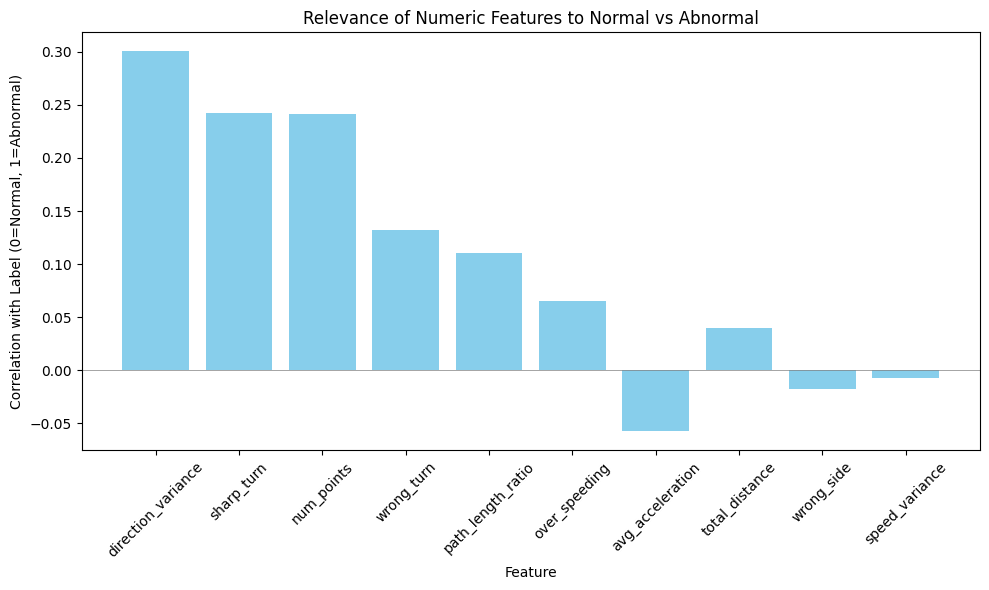


Zone Sequence Distribution by Label:


zone_sequence  1  1,1  1,1,1  1,1,1,1,1  1,1,1,1,1,1  1,1,1,1,1,1,1  \
label                                                                 
0              2    1      3          1            1              2   
1              0    0      0          0            0              0   

zone_sequence  1,1,1,1,1,1,1,1  1,1,1,1,1,1,1,1,1  1,1,1,1,1,1,1,1,1,1,1,1  \
label                                                                        
0                            1                  1                        1   
1                            0                  0                        0   

zone_sequence  1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1  ...  \
label                                             ...   
0                                              2  ...   
1                                              0  ...   

zone_sequence  3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,


Chi-Squared Test for zone_sequence vs Label:
Chi2 Statistic: 615.24, p-value: 0.1374
A low p-value (<0.05) indicates a significant association between zone_sequence and label.


In [26]:
# Calculate mean and standard deviation for numeric features only
normal_group = cleaned_df[cleaned_df['label'] == 0]
abnormal_group = cleaned_df[cleaned_df['label'] == 1]

mean_normal = normal_group[numeric_features].mean()
std_normal = normal_group[numeric_features].std()
mean_abnormal = abnormal_group[numeric_features].mean()
std_abnormal = abnormal_group[numeric_features].std()

stats_df = pd.DataFrame({
    'Mean_Normal': mean_normal,
    'Std_Normal': std_normal,
    'Mean_Abnormal': mean_abnormal,
    'Std_Abnormal': std_abnormal
})

print("\nStatistical Summary for Numeric Features by Class (Mean and Std Dev):")
display(stats_df)

# Compute point-biserial correlation between each numeric feature and the label
correlations = {}
for col in numeric_features:
    corr, _ = pointbiserialr(y, X[col])
    correlations[col] = corr

# Convert to DataFrame for display
corr_df = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Correlation'])
corr_df = corr_df.sort_values(by='Correlation', key=abs, ascending=False)

print("\nPoint-Biserial Correlation with Label (Numeric Features):")
display(corr_df)

# Visualize correlation values for numeric features
plt.figure(figsize=(10, 6))
plt.bar(corr_df['Feature'], corr_df['Correlation'], color='skyblue')
plt.axhline(0, color='gray', linewidth=0.5)
plt.xlabel('Feature')
plt.ylabel('Correlation with Label (0=Normal, 1=Abnormal)')
plt.title('Relevance of Numeric Features to Normal vs Abnormal')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze zone_sequence (categorical) separately using frequency distribution
zone_counts = cleaned_df.groupby(['label', 'zone_sequence']).size().unstack(fill_value=0)
print("\nZone Sequence Distribution by Label:")
display(zone_counts)

# Calculate a chi-squared test to assess association between zone_sequence and label
from scipy.stats import chi2_contingency
chi2, p, _, _ = chi2_contingency(zone_counts)
print(f"\nChi-Squared Test for zone_sequence vs Label:")
print(f"Chi2 Statistic: {chi2:.2f}, p-value: {p:.4f}")
print("A low p-value (<0.05) indicates a significant association between zone_sequence and label.")

In [16]:
# Summary of findings
print("\nRelevance Assessment:")
print("- Numeric features with |Correlation| > 0.3 are strong indicators for classification.")
print("- Significant differences in means between normal and abnormal classes suggest relevance.")
print("- For zone_sequence, a low p-value (<0.05) in the chi-squared test indicates relevance.")

# Highlight strongly relevant numeric features
relevant_numeric_features = corr_df[abs(corr_df['Correlation']) > 0.3]['Feature'].tolist()
if relevant_numeric_features:
    print(f"Strongly relevant numeric features: {relevant_numeric_features}")
else:
    print("No numeric features with strong correlation (|corr| > 0.3).")

# Highlight zone_sequence relevance
if p < 0.05:
    print("zone_sequence appears relevant based on the chi-squared test (p < 0.05).")
else:
    print("zone_sequence may not be strongly relevant (p >= 0.05). Consider encoding or deriving new features from it.")

# Recommendations
print("\nRecommendations:")
if relevant_numeric_features or p < 0.05:
    print("- Some features appear relevant for distinguishing normal vs abnormal tracks.")
    print("- Proceed with these features for classification or further analysis.")
else:
    print("- Features lack strong relevance. Consider the following:")
    print("  - Verify data quality: Ensure trajectories capture meaningful motion (speed, turns, etc.).")
    print("  - Feature engineering: Derive new features (e.g., zone transitions, sequence length).")
    print("  - Expand dataset: Include more diverse trajectories to increase feature variation.")


Relevance Assessment:
- Numeric features with |Correlation| > 0.3 are strong indicators for classification.
- Significant differences in means between normal and abnormal classes suggest relevance.
- For zone_sequence, a low p-value (<0.05) in the chi-squared test indicates relevance.
No numeric features with strong correlation (|corr| > 0.3).
zone_sequence may not be strongly relevant (p >= 0.05). Consider encoding or deriving new features from it.

Recommendations:
- Features lack strong relevance. Consider the following:
  - Verify data quality: Ensure trajectories capture meaningful motion (speed, turns, etc.).
  - Feature engineering: Derive new features (e.g., zone transitions, sequence length).
  - Expand dataset: Include more diverse trajectories to increase feature variation.
